# Import bibliotek oraz wczytanie danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import scipy.sparse as sp
from libreco.data import random_split, DatasetPure, split_by_ratio_chrono
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate



Instructions for updating:
non-resource variables are not supported in the long term


In [76]:
df = pd.read_csv("C:\\Users\\marci\\OneDrive\\Pulpit\\archive\\interactions.csv",
                 #"C:\\Users\\fpazi\\Desktop\\projekty\\olx\\interactions.csv",
                 sep=',')

## Basic statistics

In [239]:
df['event'].value_counts()

event
click                    58817263
contact_phone_click_1     1721338
bookmark                  1644602
chat_click                1399051
contact_chat               948470
contact_partner_click      459305
contact_phone_click_2      444497
contact_phone_click_3       67675
Name: count, dtype: int64

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [241]:
n_users = df['user'].nunique()
n_items = df['item'].nunique()

print('Number of users: ', n_users)
print('Number of items: ', n_items)

Number of users:  3295942
Number of items:  185395


In [242]:
n_events_per_user = df.groupby('user').size()
n_events_per_item = df.groupby('item').size()

print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))

Average number of events per user:  19.87  with a standard deviation of  47.762363188402105
Average number of events per item:  353.31  with a standard deviation of  624.7732106025969


In [243]:
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))

Median number of events per user:  6.0
Median number of events per item:  137.0


## Number of interactions per user

In [244]:
n_events_per_user.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
dtype: float64

<Axes: ylabel='Proportion'>

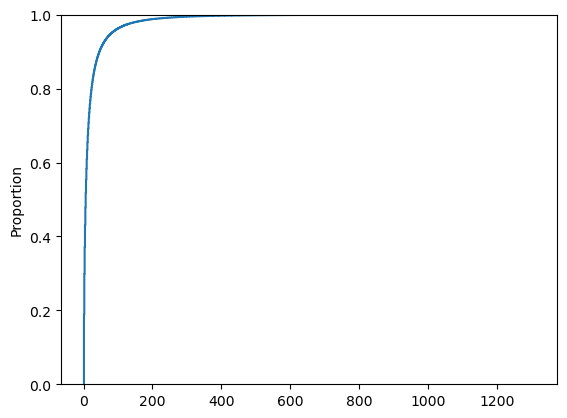

In [245]:
sns.ecdfplot(n_events_per_user)

<Axes: ylabel='Count'>

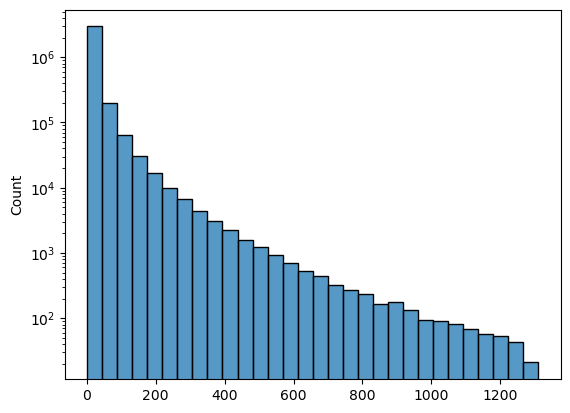

In [246]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1

Skala logarytmiczna :D events vs users/items

<Axes: >

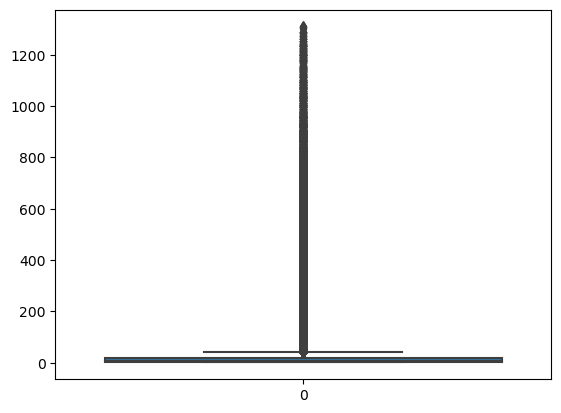

In [247]:
sns.boxplot(n_events_per_user)

<Axes: >

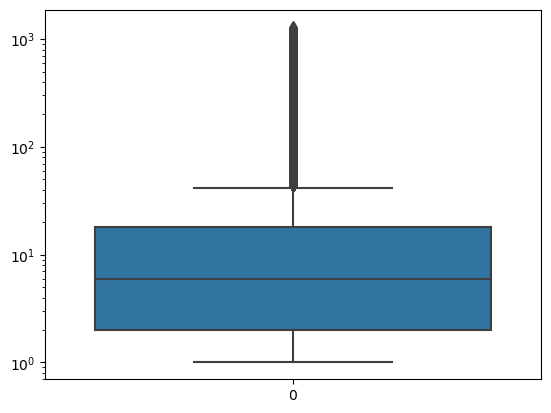

In [248]:
h = sns.boxplot(n_events_per_user)
h.set_yscale('log')
h

## Number of interactions per item

In [249]:
n_events_per_item.describe()

count    185395.000000
mean        353.311583
std         624.774896
min           1.000000
25%           3.000000
50%         137.000000
75%         428.000000
max       15480.000000
dtype: float64

<Axes: ylabel='Proportion'>

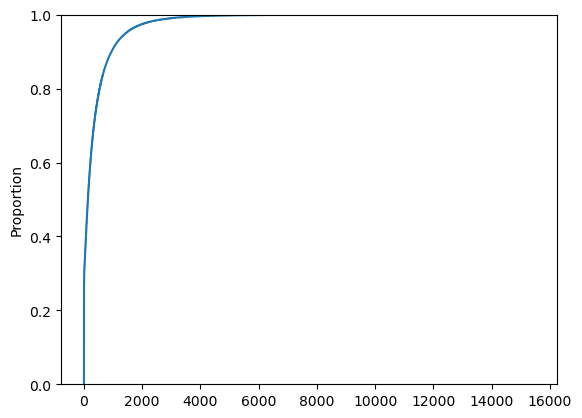

In [250]:
sns.ecdfplot(n_events_per_item)

<Axes: ylabel='Count'>

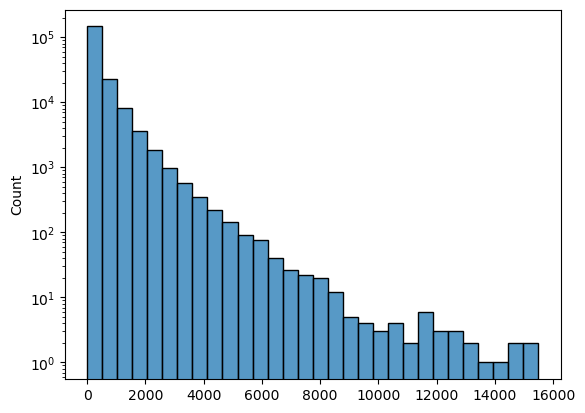

In [251]:
h2 = sns.histplot(n_events_per_item, bins=30)
h2.set_yscale("log")
h2

<Axes: >

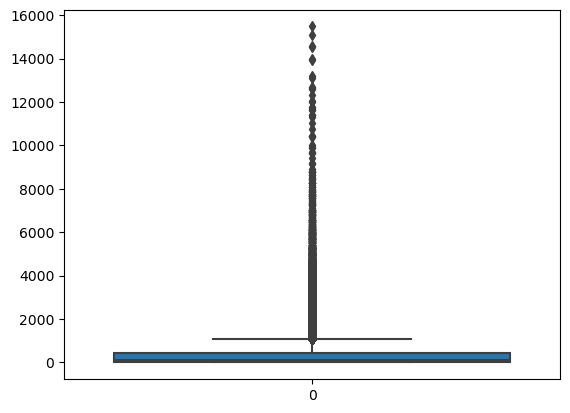

In [252]:
sns.boxplot(n_events_per_item)

<Axes: >

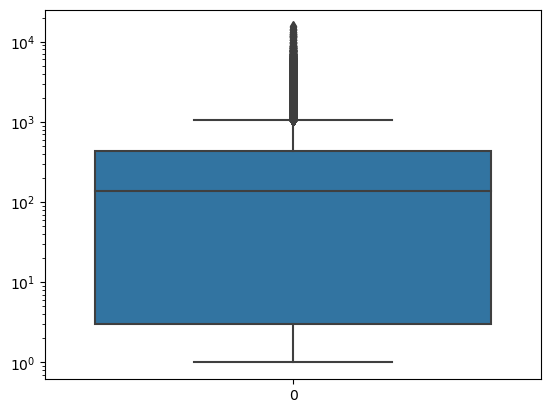

In [253]:
h4 = sns.boxplot(n_events_per_item)
h4.set_yscale('log')
h4

In [254]:
n_events_per_item = df['item'].value_counts()
n_events_per_item

item
145769    15480
171495    15092
44153     14581
41518     14544
179685    13985
          ...  
118231        1
48346         1
85236         1
138689        1
81245         1
Name: count, Length: 185395, dtype: int64

In [255]:
top_items.sort_values()

item
44689      6979
47799      6990
52647      7004
97375      7015
21203      7034
          ...  
179685    13985
41518     14544
44153     14581
171495    15092
145769    15480
Name: count, Length: 100, dtype: int64

## Wstępna obróbka danych

Podział wartości z kolumny `event` tak aby móc dostosować naszą ramkę danych do zadania. 

In [77]:
rating = {
    'click': 1,
    'bookmark': 2,
    'chat_click': 3,
    'contact_phone_click_1': 3,
    'contact_partner_click': 3,
    'contact_phone_click_2': 3,
    'contact_phone_click_3': 3,
    'contact_chat': 3
}
df['event'] = df['event'].map(rating)
df = df.rename(columns={'event': 'label'})
df = df.rename(columns={'timestamp': 'time'})

Ustawiamy liczbę interakcji użytkowników od największej do najmniejszej i sprawdzamy jak wyglądają te liczby.

In [78]:
user_interaction_counts = df['user'].value_counts()

In [10]:
user_interaction_counts

user
750207     1310
3057718    1308
2358298    1308
88606      1307
2016978    1303
           ... 
1349450       1
1508574       1
630705        1
153841        1
2598557       1
Name: count, Length: 3295942, dtype: int64

Pozbywamy się użytkowników z liczbą interakcji mniejszą niż 100. Mamy nadzieje odsiać w ten sposób użytkowników, którzy nie są regularnymi użytkownikami. Pozbywamy się outlierów korzystając z metody 8 sigm.

In [79]:
reg_users = user_interaction_counts[user_interaction_counts >= 100]
users_to_keep = reg_users[reg_users <= reg_users.mean() + 8*reg_users.std()].index
df = df[df['user'].isin(users_to_keep)]

In [12]:
n_events_per_user = df.groupby('user').size()
n_events_per_user

user
64         281
87         210
107        117
187        232
207        106
          ... 
3295867    301
3295881    156
3295889    122
3295902    192
3295918    102
Length: 123531, dtype: int64

In [66]:
df['user'].value_counts()

user
605913     1283
2094403    1279
2533767    1276
1596332    1274
1584826    1273
           ... 
2122355     100
161331      100
924630      100
420309      100
2609154     100
Name: count, Length: 123531, dtype: int64

In [5]:
df['item'].value_counts()

item
145769    15480
171495    15092
44153     14581
41518     14544
179685    13985
          ...  
118231        1
48346         1
85236         1
138689        1
81245         1
Name: count, Length: 185395, dtype: int64

<Axes: ylabel='Count'>

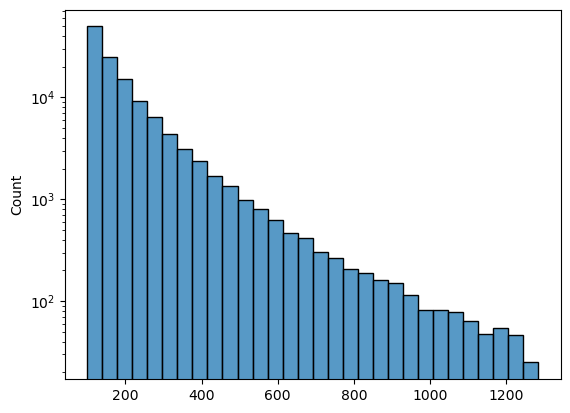

In [261]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1

<Axes: >

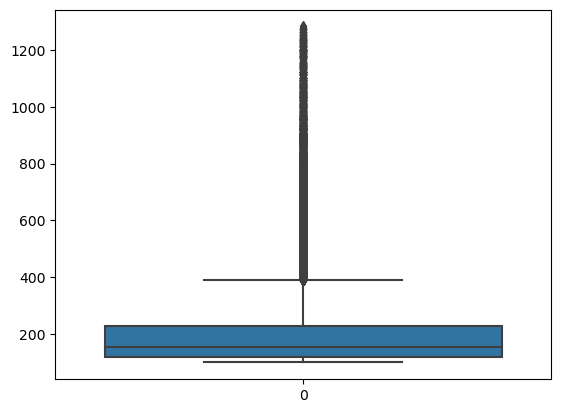

In [262]:
sns.boxplot(n_events_per_user.values)

<Axes: >

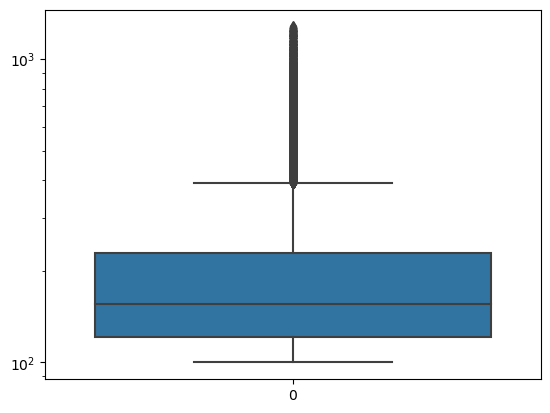

In [263]:
h = sns.boxplot(n_events_per_user.values)
h.set_yscale('log')
h

Pozbywamy się przedmiotów o mniejszej liczbie interakcji niż 1000. Mamy nadzieje, by w ten sposób, zachować przedmioty, które cieszą się przynajmniej umiarkowanym sukcesem. Pozbywamy się outlierów korzystając z metody 9 sigm.

In [80]:
item_interaction_counts = df['item'].value_counts()
popular_item = item_interaction_counts[item_interaction_counts >= 1000]
items_to_keep = popular_item[popular_item <= popular_item.mean() + 9*popular_item.std()].index
df = df[df['item'].isin(items_to_keep)].reset_index(drop=True)

In [81]:
n_events_per_item = df.groupby('item').size()
n_events_per_item.describe()

count    3291.000000
mean     1579.654512
std       700.431493
min      1000.000000
25%      1139.000000
50%      1355.000000
75%      1754.500000
max      7276.000000
dtype: float64

<Axes: ylabel='Count'>

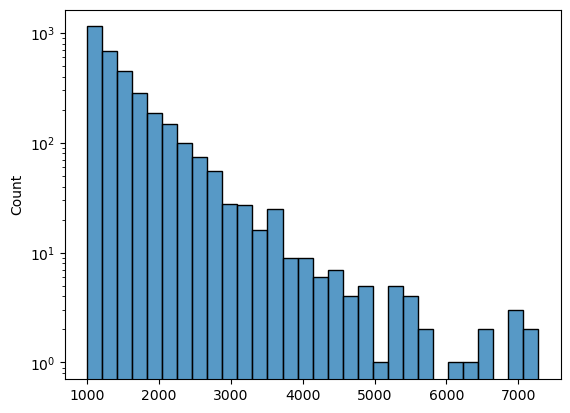

In [20]:
h2 = sns.histplot(n_events_per_item, bins=30)
h2.set_yscale("log")
h2

<Axes: >

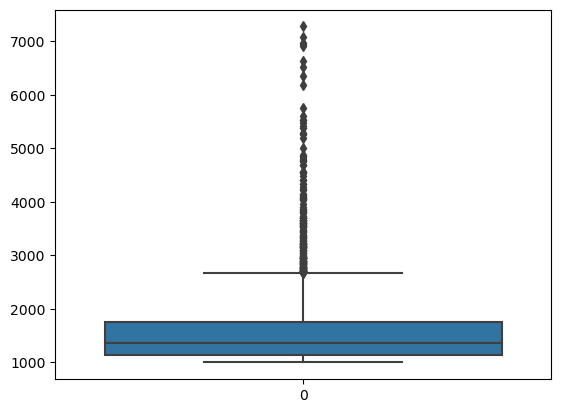

In [21]:
sns.boxplot(n_events_per_item.values)

<Axes: >

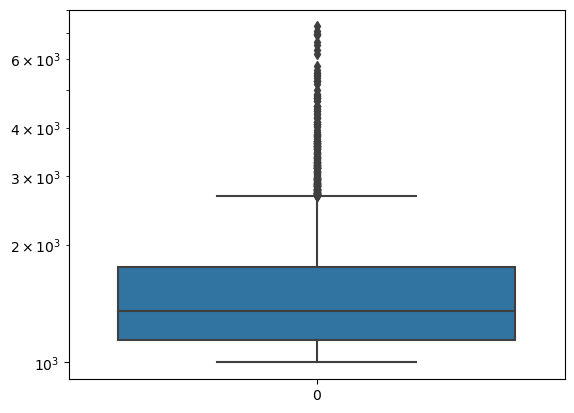

In [22]:
h4 = sns.boxplot(n_events_per_item.values)
h4.set_yscale('log')
h4

Dla tej kombinacji sigm zaobserwowałem najwyższe gęstość danych.

Pierwsza filtracja ramki danych. Wybieramy 20% przedmiotów o największej liczbie interakcji.

In [82]:
# Obliczenie liczby interakcji dla każdego użytkownika
user_interaction_counts = df['user'].value_counts()

# Obliczenie kwantyla dla top 20% użytkowników
top_20_threshold = user_interaction_counts.quantile(0.8)

# Wybór użytkowników, którzy są w top 20% o największej liczbie interakcji
top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

# Przefiltrowanie ramki danych, aby pozostawić tylko wybranych użytkowników
filtered_df = df[df['user'].isin(top_20_users)]

In [83]:
user_interaction_counts = filtered_df['user'].value_counts()

# Sortowanie przedmiotow według liczby interakcji od największej do najmniejszej
sorted_users = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie statystyk posortowanych przedmiotów
sorted_users.describe()

count    25073.000000
mean       110.118055
std         60.734549
min         61.000000
25%         72.000000
50%         89.000000
75%        124.000000
max       1074.000000
Name: count, dtype: float64

In [84]:
item_interaction_counts = filtered_df['item'].value_counts()

# Sortowanie przedmiotow według liczby interakcji od największej do najmniejszej
sorted_items = item_interaction_counts.sort_values(ascending=False)

# Wyświetlenie statystyk posortowanych przedmiotów
sorted_items.describe()

count    3291.000000
mean      838.951686
std       545.276474
min        82.000000
25%       508.000000
50%       723.000000
75%       998.500000
max      5250.000000
Name: count, dtype: float64

In [85]:
# Obliczenie liczby interakcji dla każdego przedmiotu
item_interaction_counts = df['item'].value_counts()

# Obliczenie kwantyla dla top 20% przedmiotów
top_20_threshold = item_interaction_counts.quantile(0.8)

# Wybór przedmiotów, które są w top 20% o największej liczbie interakcji
top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

# Przefiltrowanie ramki danych, aby pozostawić tylko wybrane przedmioty
filtered_df = filtered_df[filtered_df['item'].isin(top_20_items)]

In [86]:
item_interaction_counts = filtered_df['item'].value_counts()

# Sortowanie przedmiotow według liczby interakcji od największej do najmniejszej
sorted_items = item_interaction_counts.sort_values(ascending=False)

# Wyświetlenie statystyk posortowanych przedmiotów
sorted_items.describe()

count     659.000000
mean     1567.449165
std       735.653636
min       191.000000
25%      1114.000000
50%      1429.000000
75%      1811.000000
max      5250.000000
Name: count, dtype: float64

To samo robimy dla 20% użytkowników o największej liczbie interakcji.

In [87]:
item_interaction_counts = filtered_df['item'].value_counts()

# Sortowanie przedmiotów według liczby interakcji od największej do najmniejszej
sorted_items = item_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych przedmiotów
print(sorted_items.head())

user_interaction_counts = filtered_df['user'].value_counts()

# Sortowanie użytkowników według liczby interakcji od największej do najmniejszej
sorted_users = user_interaction_counts.sort_values(ascending=False)

# Wyświetlenie posortowanych użytkowników
print(sorted_users.head())

item
66717     5250
44153     5098
16819     5049
171495    4957
179685    4912
Name: count, dtype: int64
user
1288580    1054
1948352     537
2090363     484
3049290     468
239584      396
Name: count, dtype: int64


Porównujemy proporcję przedmioty / użytkownicy w wejściowej ramce danych oraz przefiltrowanej. Jak widzimy, proporcja ta jest prawie identyczna.

In [88]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df['user'].nunique()
print(count_users)
count_items = filtered_df['item'].nunique()
print(count_items)
print(count_items/count_users * 100)
count_items_before/count_users_before * 100

25060
659
2.6296887470071826


2.6695544253279144

Kolejna filtracja ramki danych. Teraz losowo wybieramy x% unikatowych przedmiotów i użytkowników tak, aby maszyny, na których pracujemy nie miały problemów z pamięcią.

In [89]:
# Procent użytkowników i przedmiotów do wyboru
sample_percent = 1

# Wybór x% unikatowych użytkowników
sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent, random_state=2024)

# Wybór x% unikatowych przedmiotów
sampled_items = filtered_df.drop_duplicates('item').sample(frac=sample_percent, random_state=2024)

# Przefiltrowanie przefiltrowanej ramki danych, aby pozostawić tylko wybrane użytkowniki
filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

# Przefiltrowanie wynikowej ramki danych, aby pozostawić tylko wybrane przedmioty
filtered_df = filtered_df_users[filtered_df_users['item'].isin(sampled_items['item'])]

Znów sprawdzmy proporcję przedmioty / użytkownicy. 

In [90]:
count_users = filtered_df['user'].nunique()
print(count_users)
count_items = filtered_df['item'].nunique()
print(count_items)
print(count_items/count_users * 100)
count_items_before/count_users_before * 100

25060
659
2.6296887470071826


2.6695544253279144

Implementujemy kod z biblioteki LibRecommender dzielący dane na zbiór treningowy i ewaluacyjny.

In [91]:
train_data, eval_data, test_data = random_split(filtered_df, multi_ratios=[0.7, 0.1, 0.2])
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 25041, n_items: 659, data density: 4.3817 %


In [92]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=32,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

In [93]:
%%time
# można też spróbować %%timeit jeśli kod się będzie w miarę krótko wykonywał (liczy średnii czas wykonywania komórki) 
lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-06 19:49:18


train: 100%|█████████████████████████████████████████████████████████████████████████| 354/354 [01:19<00:00,  4.45it/s]


Epoch 1 elapsed: 79.539s
	 train_loss: 0.4866


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 508.87it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1563.78it/s]


	 eval log_loss: 0.5156
	 eval precision@10: 0.0278
	 eval recall@10: 0.0756
	 eval ndcg@10: 0.1220
	 eval map@10: 0.0870


train: 100%|█████████████████████████████████████████████████████████████████████████| 354/354 [01:20<00:00,  4.42it/s]


Epoch 2 elapsed: 80.090s
	 train_loss: 0.2473


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 410.12it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1466.21it/s]


	 eval log_loss: 0.5132
	 eval precision@10: 0.0299
	 eval recall@10: 0.0830
	 eval ndcg@10: 0.1319
	 eval map@10: 0.0944


train: 100%|█████████████████████████████████████████████████████████████████████████| 354/354 [01:19<00:00,  4.46it/s]


Epoch 3 elapsed: 79.372s
	 train_loss: 0.2059


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 460.61it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1580.76it/s]


	 eval log_loss: 0.5192
	 eval precision@10: 0.0314
	 eval recall@10: 0.0880
	 eval ndcg@10: 0.1384
	 eval map@10: 0.0993
CPU times: total: 13min 30s
Wall time: 4min 8s


Czemu eval log loss wzrasta??

In [94]:
%%time
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 520.55it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2055/2055 [00:01<00:00, 1540.11it/s]


CPU times: total: 5.23 s
Wall time: 2.91 s


{'loss': 0.5122572777390915,
 'roc_auc': 0.9132106554920183,
 'precision': 0.05590669371196754,
 'recall': 0.09284837157274571,
 'ndcg': 0.21887501964633027,
 'map': 0.15722008456625272}

In [95]:
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=5
)

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 530.81it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2055/2055 [00:01<00:00, 1509.16it/s]


{'loss': 0.5122572777390915,
 'precision': 0.06623123732251522,
 'recall': 0.05572923901760092,
 'ndcg': 0.1795673125181513,
 'map': 0.14738381885128138}

In [96]:
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=2
)

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 541.44it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2055/2055 [00:01<00:00, 1588.11it/s]


{'loss': 0.5122572777390915,
 'precision': 0.07920892494929006,
 'recall': 0.02716131169324072,
 'ndcg': 0.1251642902352959,
 'map': 0.11728194726166329}

In [97]:
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map"],
    k=1
)

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 532.53it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2055/2055 [00:01<00:00, 1831.83it/s]


{'loss': 0.5122572777390915,
 'precision': 0.08718052738336714,
 'recall': 0.015040754044757227,
 'ndcg': 0.08718052738336714,
 'map': 0.08718052738336714}

Wszystko poniżej tego kawałka kodu to zabawy w zmianę funkcji straty, zmiana parametrów itd itp.

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=32,
    n_epochs=5,
    lr=0.001,
    batch_size=512,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

Training start time: 2024-03-06 19:54:48


train: 100%|███████████████████████████████████████████████████████████████████████| 2825/2825 [10:22<00:00,  4.54it/s]


Epoch 1 elapsed: 622.265s
	 train_loss: 0.5123


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 484.75it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1580.79it/s]


	 eval log_loss: 0.4802
	 eval precision@10: 0.0303
	 eval recall@10: 0.0847
	 eval ndcg@10: 0.1340
	 eval map@10: 0.0960


train: 100%|███████████████████████████████████████████████████████████████████████| 2825/2825 [10:24<00:00,  4.52it/s]


Epoch 2 elapsed: 624.808s
	 train_loss: 0.4737


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 446.27it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1927/1927 [00:01<00:00, 1601.83it/s]


	 eval log_loss: 0.4710
	 eval precision@10: 0.0317
	 eval recall@10: 0.0901
	 eval ndcg@10: 0.1396
	 eval map@10: 0.0997


train:  83%|███████████████████████████████████████████████████████████▏           | 2357/2825 [08:49<01:43,  4.51it/s]

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="focal",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)

In [ ]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="max_margin",
    embed_size=64,
    n_epochs=5,
    lr=1e-2,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)